# Rb-85 locking calibration
Steps:
1. Detect three SAS dips in `motlockcal.csv` (CH2), fit Lorentzian centers.
2. Calibrate sweep ? MHz using literature (X23, X34, F=3?F'4).
3. Apply to `motlock.csv`, annotate, and extract lock detuning from the negative-slope zero crossing.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

plt.rcParams["figure.dpi"] = 150

lit_rubidium = pd.DataFrame([
    ("X23", "C/O(F'=2,3)", -92.2),
    ("X34", "C/O(F'=3,4)", -60.5),
    ("F3_to_F4", "F=3 ? F'4", 0.00),
], columns=["label", "transition", "MHz"])


In [7]:
def load_trace(path, channel="CH2"):
    df = pd.read_csv(path)
    x = df["X"].iloc[1:].astype(float).to_numpy()
    y = df[channel].iloc[1:].astype(float).to_numpy()
    return x, y

def lorentz_lin(x, a0, a1, A, xc, gamma):
    return a0 + a1 * (x - xc) - A * gamma**2 / ((x - xc)**2 + gamma**2)

def find_three_dips(x, y, prominence=0.02, baseline_sigma=800, smooth_sigma=30, roi_half_width=800):
    baseline = gaussian_filter1d(y, sigma=baseline_sigma)
    resid = y - baseline
    sm = gaussian_filter1d(resid, sigma=smooth_sigma)
    candidates, _ = find_peaks(-sm, prominence=prominence, distance=int(roi_half_width * 1.5))
    candidates = sorted(candidates, key=lambda i: sm[i])[:3]
    candidates = sorted(candidates, key=lambda i: x[i])
    centers = []
    for idx in candidates:
        xc0 = x[idx]
        mask = (x > xc0 - roi_half_width) & (x < xc0 + roi_half_width)
        xr, yr = x[mask], gaussian_filter1d(y[mask], sigma=10)
        a0 = np.median(yr)
        p0 = [a0, 0.0, abs(yr.min() - a0) + 1e-3, xc0, roi_half_width / 4]
        bounds = ([-np.inf, -np.inf, 0.0, xc0 - roi_half_width, 1e-3],
                  [np.inf, np.inf, np.inf, xc0 + roi_half_width, roi_half_width])
        popt, _ = curve_fit(lorentz_lin, xr, yr, p0=p0, bounds=bounds, maxfev=20000)
        centers.append(popt[3])
    return np.array(centers), sm

def sweep_to_mhz_from_centers(centers, lit_mhz):
    A = np.vstack([centers, np.ones_like(centers)]).T
    slope, offset = np.linalg.lstsq(A, lit_mhz, rcond=None)[0]
    residuals = lit_mhz - (slope * centers + offset)
    return slope, offset, residuals

def negative_slope_zero(freq_axis, signal):
    idxs = np.where(np.diff(np.sign(signal)) != 0)[0]
    best = None
    for idx in idxs:
        y0, y1 = signal[idx], signal[idx + 1]
        if y1 == y0:
            continue
        f0, f1 = freq_axis[idx], freq_axis[idx + 1]
        fz = f0 - y0 * (f1 - f0) / (y1 - y0)
        slope_local = signal[idx + 1] - (signal[idx - 1] if idx > 0 else signal[idx])
        if slope_local < 0:
            if best is None or abs(fz) < abs(best[0]):
                best = (fz, idx, slope_local)
    return best


Calibration dips (sweep units): [ 4769.58089444  9685.69561483 17902.76909058]
MHz = 0.007055532 * sweep + -127.001
Residuals vs literature (MHz): [ 1.14914718 -1.83665952  0.68751233]


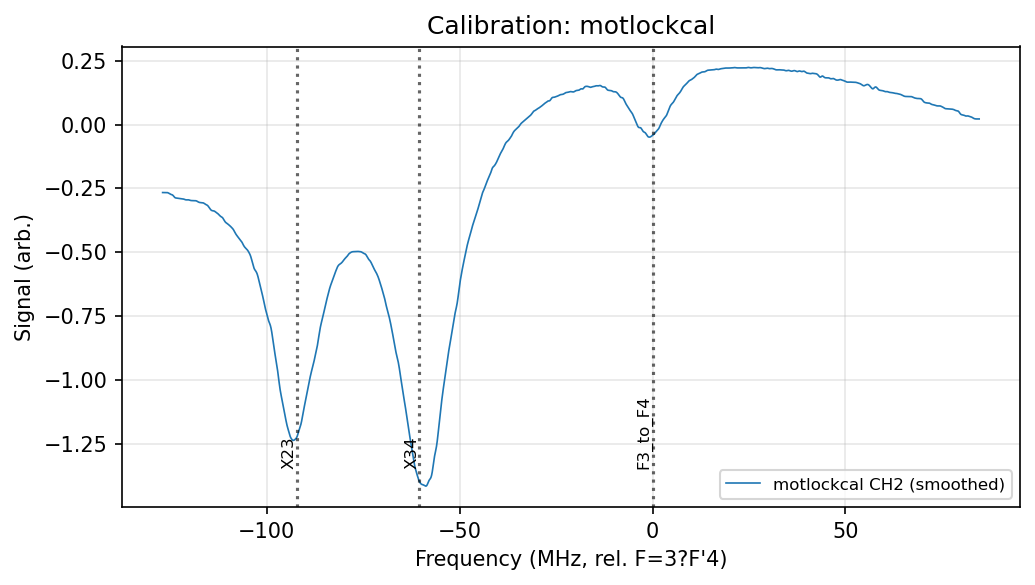

In [8]:
cal_path = Path("motlockcal.csv")
x_cal, y_cal = load_trace(cal_path, "CH2")

centers, cal_sm = find_three_dips(x_cal, y_cal)
lit_mhz = lit_rubidium["MHz"].to_numpy()
slope, offset, residuals = sweep_to_mhz_from_centers(centers, lit_mhz)

print("Calibration dips (sweep units):", centers)
print(f"MHz = {slope:.9f} * sweep + {offset:.3f}")
print("Residuals vs literature (MHz):", residuals)

freq_cal = slope * x_cal + offset
y_cal_sm = gaussian_filter1d(y_cal, sigma=40)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(freq_cal, y_cal_sm, lw=0.8, label="motlockcal CH2 (smoothed)")
for _, row in lit_rubidium.iterrows():
    ax.axvline(row["MHz"], color="k", ls=":", alpha=0.6)
    ax.text(row["MHz"], ax.get_ylim()[0] * 0.9, row["label"], rotation=90,
            ha="right", va="bottom", fontsize=8)
ax.set_xlabel("Frequency (MHz, rel. F=3?F'4)")
ax.set_ylabel("Signal (arb.)")
ax.set_title("Calibration: motlockcal")
ax.grid(alpha=0.3)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()


Lock detuning (negative-slope zero nearest 0): +11.91 MHz


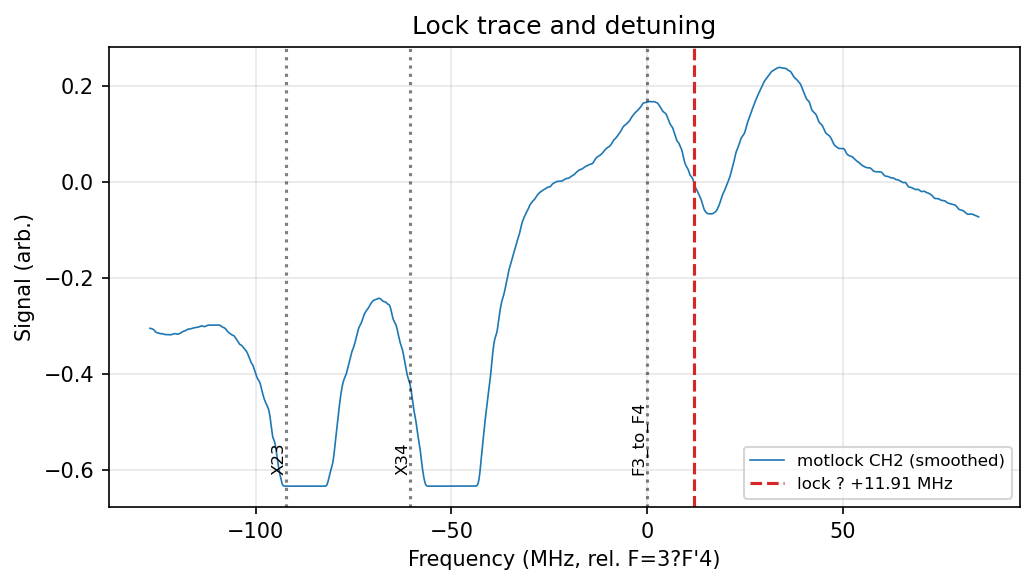

In [9]:
lock_path = Path("motlock.csv")
x_lock, y_lock = load_trace(lock_path, "CH2")
y_lock_sm = gaussian_filter1d(y_lock, sigma=40)
freq_lock = slope * x_lock + offset

lock_point = negative_slope_zero(freq_lock, y_lock_sm)
if lock_point:
    detuning_mhz = lock_point[0]
    print(f"Lock detuning (negative-slope zero nearest 0): {detuning_mhz:+.2f} MHz")
else:
    detuning_mhz = None
    print("No negative-slope zero crossing found.")

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(freq_lock, y_lock_sm, lw=0.8, label="motlock CH2 (smoothed)")
for _, row in lit_rubidium.iterrows():
    ax.axvline(row["MHz"], color="k", ls=":", alpha=0.5)
    ax.text(row["MHz"], ax.get_ylim()[0] * 0.9, row["label"], rotation=90,
            ha="right", va="bottom", fontsize=8)
if detuning_mhz is not None:
    ax.axvline(detuning_mhz, color="C3", ls="--", label=f"lock ? {detuning_mhz:+.2f} MHz")
ax.set_xlabel("Frequency (MHz, rel. F=3?F'4)")
ax.set_ylabel("Signal (arb.)")
ax.set_title("Lock trace and detuning")
ax.grid(alpha=0.3)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()
